# 랜덤함수 결과 분포 시각화

파이썬 표준 라이브러리의 `random`, `secrets` 그리고 임의로 만든 랜덤 라이브러리인 `somerand`와 `badrand = somerand % 20000`의 분포를 직접 그려보고, 품질을 확인해보겠다.

In [2]:
import random
import secrets

import numpy as np
import numpy.typing as npt
import pandas as pd
from scipy.stats import chi2
from plotly import express as px

state = 0


def somerand_init(seed: int = 1) -> None:
    global state
    state = seed & 0xFFFFFFFF


def somerand_get() -> int:
    global state
    state = (state * 1103515245 + 12345) & 0xFFFFFFFF
    return (state // 65536) % 32768


def badrand_get() -> int:
    return somerand_get() % 20000


def chi_square_test(rand: callable) -> tuple[float, npt.NDArray[np.uint32]]:
    bins = np.zeros(32768, dtype=np.uint32)
    sample_num = 1000000
    for _ in range(sample_num):
        bins[rand()] += 1

    # Chi-squared test
    e_i = sample_num / len(bins)  # Expected frequency for each bin
    chi_square = sum((o_i - e_i) ** 2 / e_i for o_i in bins)
    degrees_of_freedom = len(bins) - 1  # Number of bins - 1
    p_value = chi2.sf(chi_square, degrees_of_freedom)

    return p_value, bins


random.seed(1)
somerand_init(1)

p_random, dist_random = chi_square_test(lambda: random.randrange(32768))
p_secrets, dist_secrets = chi_square_test(lambda: secrets.randbelow(32768))
p_somerand, dist_somerand = chi_square_test(somerand_get)
p_badrand, dist_badrand = chi_square_test(badrand_get)

x = np.arange(len(dist_random))
df = pd.DataFrame(
    {
        "bin": np.tile(x, 4),
        "count": np.concatenate(
            [dist_random, dist_secrets, dist_somerand, dist_badrand]
        ),
        "method": (
            ["random.randrange"] * len(x)
            + ["secrets.randbelow"] * len(x)
            + ["somerand_get"] * len(x)
            + ["badrand_get"] * len(x)
        ),
    }
)

세 랜덤함수의 분포가 대체로 uniform해보이는걸 알 수 있고, badrand는 한눈에 봐도 분포가 일정하지 않다.

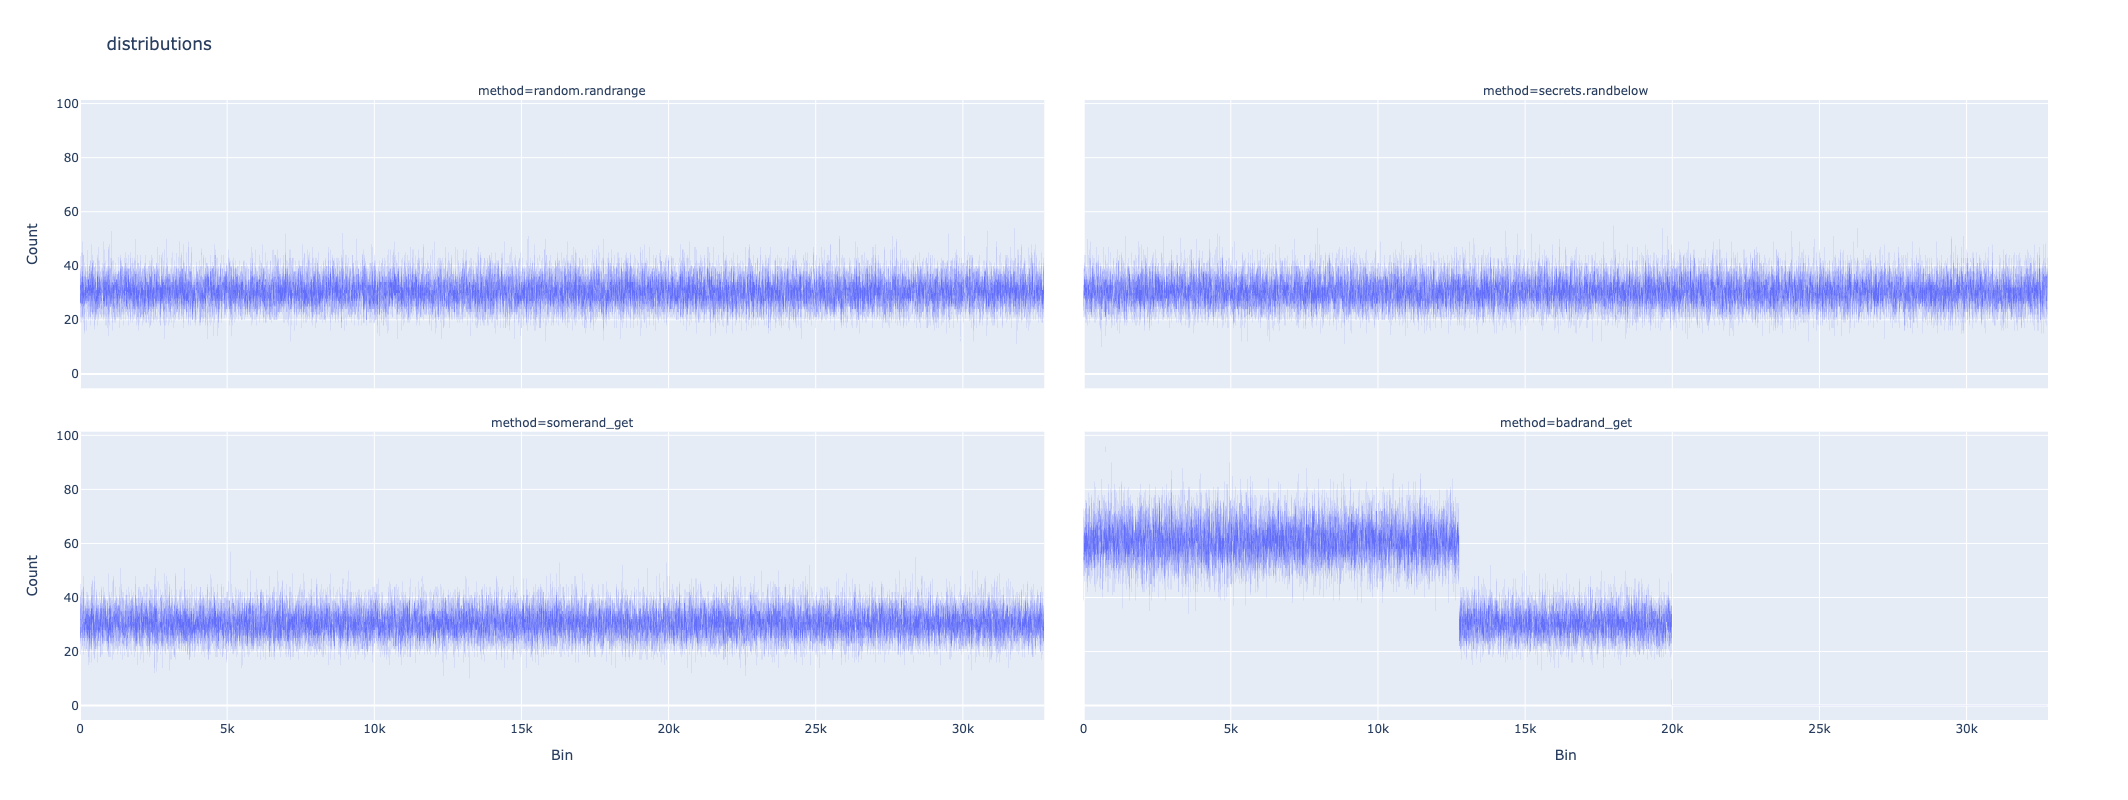

In [3]:
fig = px.line(
    df,
    x="bin",
    y="count",
    facet_col="method",
    facet_col_wrap=2,
    title="distributions",
    labels={"bin": "Bin", "count": "Count"},
)
fig.update_layout(showlegend=False, height=800, width=1200)
fig.update_traces(line_width=0.1)
fig.show()

빈도를 히스토그램으로 그려보면, 앞의 세 함수는 의도한대로 이항분포 모양을 보여주고, badrand는 두개의 이항분포가 겹친 모양이다.

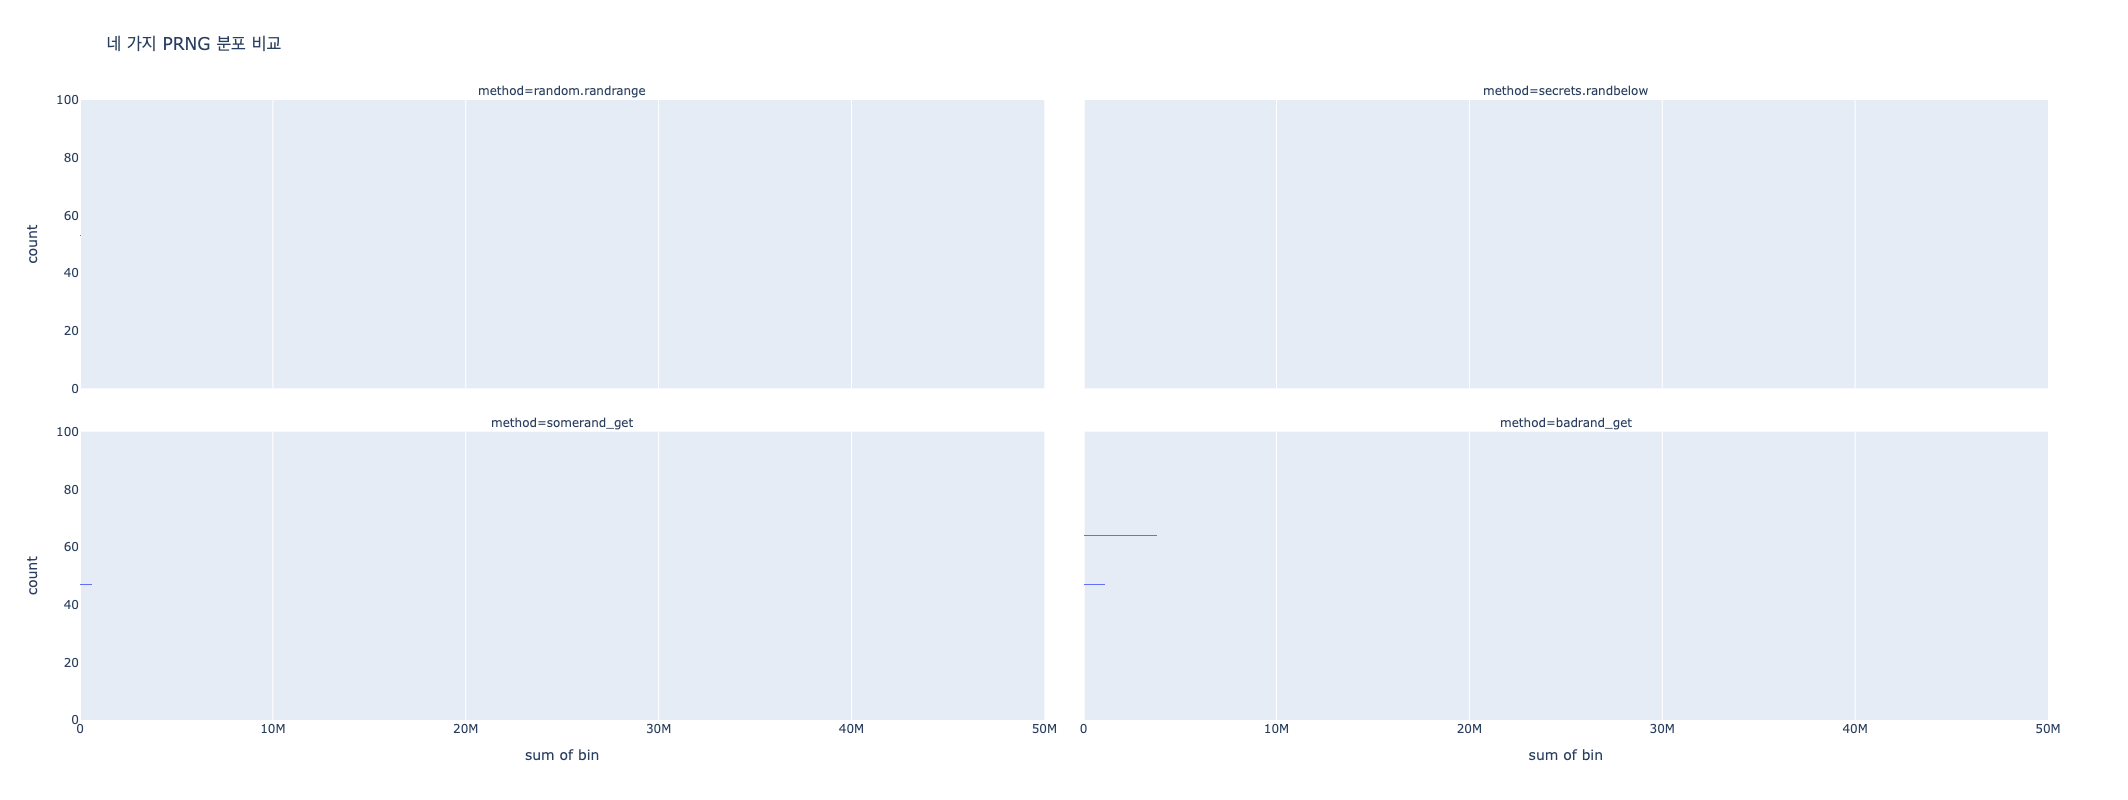

In [5]:
fig = px.histogram(
    df,
    x="bin",
    y="count",
    histfunc="sum",  # 같은 bin 값에 대해 'count'를 합산
    facet_col="method",
    facet_col_wrap=2,
    nbins=len(x),  # 각 정수값마다 하나의 빈으로 매핑
    title="네 가지 PRNG 분포 비교",
    range_x=[0, 50_000_000],
    range_y=[0, 100],
)
fig.update_layout(showlegend=False, height=800, width=1200)
fig.show()

카이제곱검정을 해보면 결과가 아래와 같다. P-value가 α(유의수준) = 0.01 미만이면 균등하지 못한것이다.

`badrand_get()`은 통계적 편항이 존재한다고 말할 수 있다.

In [8]:
pd.DataFrame(
    {
        "Method": [
            "random.randrange",
            "secrets.randbelow",
            "somerand_get",
            "badrand_get",
        ],
        "P-value": [p_random, p_secrets, p_somerand, p_badrand],
    }
)

,Method,P-value
0,random.randrange,0.822861
1,secrets.randbelow,0.041089
2,somerand_get,0.494039
3,badrand_get,0.000000
